In [11]:
import seaborn as sb
import torch
import torch.nn as nn
from torch.autograd import Variable
from scipy.optimize import linear_sum_assignment
import scipy
import scipy.optimize
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import sklearn as sk
import networkx as nx


class FocalLoss(nn.Module):
    r"""
    This criterion is a implemenation of Focal Loss, which is proposed in
    Focal Loss for Dense Object Detection.

        Loss(x, class) = - \alpha (1-softmax(x)[class])^gamma \log(softmax(x)[class])

    The losses are averaged across observations for each minibatch.

    Args:
        alpha(1D Tensor, Variable) : the scalar factor for this criterion
        gamma(float, double) : gamma > 0; reduces the relative loss for well-classiﬁed examples (p > .5),
                               putting more focus on hard, misclassiﬁed examples
        size_average(bool): By default, the losses are averaged over observations for each minibatch.
                            However, if the field size_average is set to False, the losses are
                            instead summed for each minibatch.


    """

    def __init__(self, class_num, alpha=None, gamma=2, size_average=True):
        super(FocalLoss, self).__init__()
        if alpha is None:
            self.alpha = Variable(torch.ones(class_num, 1))
        else:
            if isinstance(alpha, Variable):
                self.alpha = alpha
            else:
                self.alpha = Variable(alpha)
        self.gamma = gamma
        self.class_num = class_num
        self.size_average = size_average

    def forward(self, inputs, targets):
        N = inputs.size(0)
        C = inputs.size(1)
        # P = F.softmax(inputs)
        P = inputs

        class_mask = inputs.data.new(N, C).fill_(0)
        class_mask = Variable(class_mask)
        ids = targets.view(-1, 1)
        class_mask.scatter_(1, ids.data, 1.0)
        # print(class_mask)

        if inputs.is_cuda and not self.alpha.is_cuda:
            self.alpha = self.alpha.cuda()
        alpha = self.alpha[ids.data.view(-1)]

        probs = (P * class_mask).sum(1).view(-1, 1)

        log_p = probs.log()
        # print('probs size= {}'.format(probs.size()))
        # print(probs)

        batch_loss = -alpha * (torch.pow((1 - probs), self.gamma)) * log_p
        # print('-----bacth_loss------')
        # print(batch_loss)

        if self.size_average:
            loss = batch_loss.mean()
        else:
            loss = batch_loss.sum()
        return loss


class HungarianLoss:
    def __init__(self, predictions, targets, mask):
        self.predictions = predictions
        self.targets = targets
        self.mask = mask

    def outer(self, a, b=None):
        if b is None:
            b = a
        size_a = tuple(a.size()) + (b.size()[-1],)
        size_b = tuple(b.size()) + (a.size()[-1],)
        a = a.unsqueeze(dim=-1).expand(*size_a)
        b = b.unsqueeze(dim=-2).expand(*size_b)
        return a, b

    def per_sample_hungarian_loss(self, sample_np):
        row_idx, col_idx = scipy.optimize.linear_sum_assignment(sample_np)
        return row_idx, col_idx

    def hungarian_loss(self):
        # predictions and targets shape :: (n, c, s)
        predictions = self.predictions[: self.mask, :]
        targets = self.targets[: self.mask, :]
        predictions = predictions.permute(0, 2, 1)
        targets = targets.permute(0, 2, 1)
        predictions, targets = self.outer(predictions, targets)
        # squared_error shape :: (n, s, s)
        squared_error = (predictions - targets).pow(2).mean(1)

        squared_error_np = squared_error.detach().cpu().numpy()
        indices = [self.per_sample_hungarian_loss(x) for x in squared_error_np]
        losses = [sample[row_idx, col_idx].mean() for sample, (row_idx, col_idx) in zip(squared_error, indices)]
        total_loss = torch.mean(torch.stack(list(losses)))
        return total_loss


# Chamfer Loss, a more native and effecient loss calculation
def chamfer_loss(predictions, targets, mask):
    if mask == 0:
        return 0
    predictions = predictions[:, :mask, :]
    targets = targets[:, :mask, :]
    # predictions and targets shape :: (n, c, s)
    predictions, targets = outer(predictions, targets)
    # squared_error shape :: (n, s, s)
    squared_error = (predictions - targets).pow(2).mean(1)
    loss = squared_error.min(1)[0] + squared_error.min(2)[0]
    return loss.mean()


def outer(a, b=None):
    if b is None:
        b = a
    size_a = tuple(a.size()) + (b.size()[-1],)
    size_b = tuple(b.size()) + (a.size()[-1],)
    a = a.unsqueeze(dim=-1).expand(*size_a)
    b = b.unsqueeze(dim=-2).expand(*size_b)
    return a, b


def per_sample_hungarian_loss(sample_np):
    sample_np[sample_np == np.inf] = 0
    row_idx, col_idx = scipy.optimize.linear_sum_assignment(sample_np)
    return row_idx, col_idx


## Two implementation for hungarian_loss (hungarian matching)
def hungarian_loss1(boxesA, boxesB, mask, maximize=True):
    # print(mask)
    boxesA = boxesA[:mask, :]
    boxesB = boxesB[:mask, :]
    n = max(len(boxesA), len(boxesB))
    cost_matrix = torch.zeros((n, n))
    # print(n)

    for i, boxA in enumerate(boxesA):
        for j, boxB in enumerate(boxesB):
            if boxA is None or boxB is None:
                cost_matrix[i, j] = int(not maximize)
            else:
                cost_matrix[i, j] = torch.norm(boxA - boxB)
    cost_matrix = cost_matrix.detach().cpu().numpy()
    row_ind, col_ind = linear_sum_assignment(cost_matrix, maximize=maximize)
    return torch.mean(torch.FloatTensor(cost_matrix[row_ind, col_ind]))


def hungarian_loss(predictions, targets, mask):
    # predictions and targets shape :: (n, c, s)
    predictions = predictions[:, :mask, :]
    targets = targets[:, :mask, :]
    predictions = predictions.permute(0, 2, 1)
    targets = targets.permute(0, 2, 1)
    predictions, targets = outer(predictions, targets)
    # squared_error shape :: (n, s, s)
    squared_error = torch.sqrt((predictions - targets).pow(2).mean(1))
    squared_error_np = squared_error.detach().cpu().numpy()
    indices = [per_sample_hungarian_loss(x) for x in squared_error_np]
    # print(indices)
    losses = [sample[row_idx, col_idx].mean() for sample, (row_idx, col_idx) in zip(squared_error, indices)]
    total_loss = torch.mean(torch.stack(list(losses)))
    return total_loss, indices[0][1]


class NodeClassificationDataset(Dataset):
    def __init__(self, node_embeddings, labels):
        self.len = node_embeddings.shape[0]
        self.x_data = node_embeddings
        self.y_data = labels.long()

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len


def cluster_graph(role_id, node_embeddings):
    colors = role_id
    nb_clust = len(np.unique(role_id))
    pca = PCA(n_components=5)
    trans_data = pca.fit_transform(StandardScaler().fit_transform(node_embeddings.cpu().detach()))
    km = KMeans(n_clusters=nb_clust)
    km.fit(trans_data)
    labels_pred = km.labels_

    ######## Params for plotting
    cmapx = plt.get_cmap("rainbow")
    x = np.linspace(0, 1, nb_clust + 1)
    col = [cmapx(xx) for xx in x]
    markers = {0: "*", 1: ".", 2: ",", 3: "o", 4: "v", 5: "^", 6: "<", 7: ">", 8: 3, 9: "d", 10: "+", 11: "x", 12: "D", 13: "|", 14: "_", 15: 4, 16: 0, 17: 1, 18: 2, 19: 6, 20: 7}

    for c in np.unique(role_id):
        indc = [i for i, x in enumerate(role_id) if x == c]
        plt.scatter(trans_data[indc, 0], trans_data[indc, 1], c=np.array(col)[list(np.array(labels_pred)[indc])], marker=markers[c % len(markers)], s=300)

    labels = role_id
    for label, c, x, y in zip(labels, labels_pred, trans_data[:, 0], trans_data[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
    # plt.show()
    return labels_pred, colors, trans_data, nb_clust


def unsupervised_evaluate(colors, labels_pred, trans_data, nb_clust):
    ami = sk.metrics.adjusted_mutual_info_score(colors, labels_pred)
    sil = sk.metrics.silhouette_score(trans_data, labels_pred, metric="euclidean")
    ch = sk.metrics.calinski_harabasz_score(trans_data, labels_pred)
    hom = sk.metrics.homogeneity_score(colors, labels_pred)
    comp = sk.metrics.completeness_score(colors, labels_pred)
    # print('Homogeneity \t Completeness \t AMI \t nb clusters \t CH \t  Silhouette \n')
    # print(str(hom) + '\t' + str(comp) + '\t' + str(ami) + '\t' + str(nb_clust) + '\t' + str(ch) + '\t' + str(sil))
    return hom, comp, ami, nb_clust, ch, sil


def draw_pca(role_id, node_embeddings, coloring):
    pca = PCA(n_components=2)
    node_embedded = StandardScaler().fit_transform(node_embeddings.cpu().detach())
    principalComponents = pca.fit_transform(node_embedded)
    principalDf = pd.DataFrame(data=principalComponents, columns=["principal component 1", "principal component 2"])
    principalDf["target"] = role_id
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel("Principal Component 1", fontsize=15)
    ax.set_ylabel("Principal Component 2", fontsize=15)
    ax.set_title("2 PCA Components", fontsize=20)
    targets = np.unique(role_id)
    for target in zip(targets):
        color = coloring[target[0]]
        indicesToKeep = principalDf["target"] == target
        ax.scatter(principalDf.loc[indicesToKeep, "principal component 1"], principalDf.loc[indicesToKeep, "principal component 2"], s=50, c=color)
    ax.legend(targets)
    ax.grid()
    plt.show()


def graph_generator(width_basis=15, basis_type="cycle", n_shapes=5, shape_list=[[["house"]]], identifier="AA", add_edges=0):
    ################################### EXAMPLE TO BUILD A SIMPLE REGULAR STRUCTURE ##########
    ## REGULAR STRUCTURE: the most simple structure:  basis + n small patterns of a single type
    ### 1. Choose the basis (cycle, torus or chain)
    ### 2. Add the shapes
    list_shapes = []
    for shape in shape_list:
        list_shapes += shape * n_shapes
    print(list_shapes)

    ### 3. Give a name to the graph
    name_graph = "houses" + identifier
    sb.set_style("white")

    ### 4. Pass all these parameters to the Graph Structure
    G, communities, plugins, role_id = build_graph.build_structure(width_basis, basis_type, list_shapes, start=0, add_random_edges=add_edges, plot=True, savefig=False)
    return G, role_id


def average(lst):
    return sum(lst) / len(lst)


def write_graph2edgelist(G, role_id, filename):
    nx.write_edgelist(G, "{}.edgelist".format(filename), data=False)
    with open("{}.roleid".format(filename), "w") as f:
        for id in role_id:
            f.write(str(id) + "\n")


def set_pca(pca, embeddings):
    node_embedded = StandardScaler().fit_transform(embeddings)
    pca.fit(node_embedded)
    return pca

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# MLP with linear outputs (without softmax)
class MLP(nn.Module):
    def __init__(self, num_layers, input_dim, hidden_dim, output_dim):
        """
        num_layers: number of layers in the neural networks (EXCLUDING the input layer). If num_layers=1, this reduces to linear model.
        input_dim: dimensionality of input features
        hidden_dim: dimensionality of hidden units at ALL layers
        output_dim: number of classes for prediction
        device: which device to use
        """

        super(MLP, self).__init__()

        self.linear_or_not = True  # default is linear model
        self.num_layers = num_layers

        if num_layers < 1:
            raise ValueError("number of layers should be positive!")
        elif num_layers == 1:
            # Linear model
            self.linear = nn.Linear(input_dim, output_dim)
        else:
            # Multi-layer model
            self.linear_or_not = False
            self.linears = torch.nn.ModuleList()
            self.batch_norms = torch.nn.ModuleList()

            self.linears.append(nn.Linear(input_dim, hidden_dim))
            for layer in range(num_layers - 2):
                self.linears.append(nn.Linear(hidden_dim, hidden_dim))
            self.linears.append(nn.Linear(hidden_dim, output_dim))

            for layer in range(num_layers - 1):
                self.batch_norms.append(nn.BatchNorm1d((hidden_dim)))

    def forward(self, x):
        if self.linear_or_not:
            # If linear model
            return self.linear(x)
        else:
            # If MLP
            h = x
            for layer in range(self.num_layers - 1):
                h = F.relu(self.batch_norms[layer](self.linears[layer](h)))
            return self.linears[self.num_layers - 1](h)


class MLP_generator(nn.Module):
    def __init__(self, input_dim, output_dim, sample_size):
        super(MLP_generator, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.linear2 = nn.Linear(output_dim, output_dim)
        self.linear3 = nn.Linear(output_dim, output_dim)
        self.linear4 = nn.Linear(output_dim, output_dim)

    def forward(self, embedding, device):
        neighbor_embedding = F.relu(self.linear(embedding))
        neighbor_embedding = F.relu(self.linear2(neighbor_embedding))
        neighbor_embedding = F.relu(self.linear3(neighbor_embedding))
        neighbor_embedding = self.linear4(neighbor_embedding)
        return neighbor_embedding


class PairNorm(nn.Module):
    def __init__(self, mode="PN", scale=10):
        """
        mode:
          'None' : No normalization
          'PN'   : Original version
          'PN-SI'  : Scale-Individually version
          'PN-SCS' : Scale-and-Center-Simultaneously version

        ('SCS'-mode is not in the paper but we found it works well in practice,
          especially for GCN and GAT.)
        PairNorm is typically used after each graph convolution operation.
        """
        assert mode in ["None", "PN", "PN-SI", "PN-SCS"]
        super(PairNorm, self).__init__()
        self.mode = mode
        self.scale = scale

        # Scale can be set based on origina data, and also the current feature lengths.
        # We leave the experiments to future. A good pool we used for choosing scale:
        # [0.1, 1, 10, 50, 100]

    def forward(self, x):
        if self.mode == "None":
            return x
        col_mean = x.mean(dim=0)
        if self.mode == "PN":
            x = x - col_mean
            rownorm_mean = (1e-6 + x.pow(2).sum(dim=1).mean()).sqrt()
            x = self.scale * x / rownorm_mean
        if self.mode == "PN-SI":
            x = x - col_mean
            rownorm_individual = (1e-6 + x.pow(2).sum(dim=1, keepdim=True)).sqrt()
            x = self.scale * x / rownorm_individual
        if self.mode == "PN-SCS":
            rownorm_individual = (1e-6 + x.pow(2).sum(dim=1, keepdim=True)).sqrt()
            x = self.scale * x / rownorm_individual - col_mean
        return x


# FNN
class FNN(nn.Module):
    def __init__(self, in_features, hidden, out_features, layer_num):
        super(FNN, self).__init__()
        self.linear1 = MLP(layer_num, in_features, hidden, out_features)
        self.linear2 = nn.Linear(out_features, out_features)

    def forward(self, embedding):
        x = self.linear1(embedding)
        x = self.linear2(F.relu(x))
        return x

In [97]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv, GCNConv, SAGEConv
import random
import math


# generate ground truth neighbors Hv
def generate_gt_neighbor(neighbor_dict, node_embeddings, neighbor_num_list, in_dim):
    max_neighbor_num = max(neighbor_num_list)
    all_gt_neighbor_embeddings = []
    for i, embedding in enumerate(node_embeddings):
        neighbor_indexes = neighbor_dict[i]
        neighbor_embeddings = []
        for index in neighbor_indexes:
            neighbor_embeddings.append(node_embeddings[index].tolist())
        if len(neighbor_embeddings) < max_neighbor_num:
            for _ in range(max_neighbor_num - len(neighbor_embeddings)):
                neighbor_embeddings.append(torch.zeros(in_dim).tolist())
        all_gt_neighbor_embeddings.append(neighbor_embeddings)
    return all_gt_neighbor_embeddings


# Main Autoencoder structure here
class GNNStructEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, layer_num, sample_size, device, neighbor_num_list, GNN_name="GIN", norm_mode="PN-SCS", norm_scale=20, lambda_loss1=0.0001, lambda_loss2=1):
        """
        Main Autoencoder structure
        INPUT:
        -----------------------
        in_dim    :    input graph feature dimension
        hidden_dim     :   latent variable feature dimension
        layer_num    :    GIN encoder, number of MLP layer
        sample_size     :    number of neighbors sampled
        device     :   CPU or GPU
        neighbor_num_list    :    number of neighbors for a specific node
        norm   :   Pair Norm from https://openreview.net/forum?id=rkecl1rtwB
        lambda_loss    :   Trade-off between degree loss and neighborhood reconstruction loss
        """
        super(GNNStructEncoder, self).__init__()
        self.norm = PairNorm(norm_mode, norm_scale)
        self.out_dim = hidden_dim
        self.lambda_loss1 = lambda_loss1
        self.lambda_loss2 = lambda_loss2
        # GNN Encoder
        if GNN_name == "GIN":
            self.linear1 = MLP(layer_num, in_dim, hidden_dim, hidden_dim)
            self.graphconv1 = GINConv(nn=self.linear1)

            self.linear2 = MLP(layer_num, hidden_dim, hidden_dim, hidden_dim)
            self.graphconv2 = GINConv(nn=self.linear2)

            self.linear3 = MLP(layer_num, hidden_dim, hidden_dim, hidden_dim)
            self.graphconv3 = GINConv(nn=self.linear3)

            self.linear4 = MLP(layer_num, hidden_dim, hidden_dim, hidden_dim)
            self.graphconv4 = GINConv(nn=self.linear4)

        elif GNN_name == "GCN":
            self.graphconv1 = GCNConv(in_dim, hidden_dim)
            self.graphconv2 = GCNConv(hidden_dim, hidden_dim)
            self.graphconv3 = GCNConv(hidden_dim, hidden_dim)
            self.graphconv4 = GCNConv(hidden_dim, hidden_dim)

        else:  # SAGE
            self.graphconv1 = SAGEConv(in_dim, hidden_dim, aggr="mean")
            self.graphconv2 = SAGEConv(hidden_dim, hidden_dim, aggr="mean")
            self.graphconv3 = SAGEConv(hidden_dim, hidden_dim, aggr="mean")
            self.graphconv4 = SAGEConv(hidden_dim, hidden_dim, aggr="mean")

        self.neighbor_num_list = neighbor_num_list
        self.neighbor_generator = MLP_generator(hidden_dim, hidden_dim, sample_size).to(device)

        self.gaussian_mean = nn.Parameter(torch.FloatTensor(sample_size, hidden_dim).uniform_(-0.5 / hidden_dim, 0.5 / hidden_dim)).to(device)
        self.gaussian_log_sigma = nn.Parameter(torch.FloatTensor(sample_size, hidden_dim).uniform_(-0.5 / hidden_dim, 0.5 / hidden_dim)).to(device)
        self.m = torch.distributions.Normal(torch.zeros(sample_size, hidden_dim), torch.ones(sample_size, hidden_dim))

        self.m_h = torch.distributions.Normal(torch.zeros(sample_size, hidden_dim), 50 * torch.ones(sample_size, hidden_dim))

        # Before MLP Gaussian Means, and std

        self.mlp_gaussian_mean = nn.Parameter(torch.FloatTensor(hidden_dim).uniform_(-0.5 / hidden_dim, 0.5 / hidden_dim)).to(device)
        self.mlp_gaussian_log_sigma = nn.Parameter(torch.FloatTensor(hidden_dim).uniform_(-0.5 / hidden_dim, 0.5 / hidden_dim)).to(device)
        self.mlp_m = torch.distributions.Normal(torch.zeros(hidden_dim), torch.ones(hidden_dim))

        self.mlp_mean = nn.Linear(hidden_dim, hidden_dim)
        self.mlp_sigma = nn.Linear(hidden_dim, hidden_dim)

        self.layer1_generator = MLP_generator(hidden_dim, hidden_dim, sample_size)
        self.layer2_generator = MLP_generator(hidden_dim, hidden_dim, sample_size)
        self.layer3_generator = MLP_generator(hidden_dim, hidden_dim, sample_size)
        self.layer4_generator = MLP_generator(hidden_dim, hidden_dim, sample_size)
        # Decoders
        self.degree_decoder = FNN(hidden_dim, hidden_dim, 1, 4)
        self.feature_decoder = FNN(hidden_dim, hidden_dim, in_dim, 3)
        # self.degree_loss_func = FocalLoss(int(max_degree_num) + 1)
        self.degree_loss_func = nn.MSELoss()
        self.feature_loss_func = nn.MSELoss()
        self.in_dim = in_dim
        self.sample_size = sample_size
        self.init_projection = FNN(in_dim, hidden_dim, hidden_dim, 1)

    def forward_encoder(self, g, h):
        h0 = h
        l1 = self.graphconv1(h0, g.edge_index)
        l1_norm = torch.relu(self.norm(l1))
        l2 = self.graphconv2(l1_norm, g.edge_index)
        l2_norm = torch.relu(self.norm(l2))
        l3 = self.graphconv3(l2_norm, g.edge_index)
        l3_norm = torch.relu(self.norm(l3))
        l4 = self.graphconv4(l3_norm, g.edge_index)

        return l4, l3_norm, l2_norm, l1_norm, h0

    # Sample neighbors from neighbor set, if the length of neighbor set less than sample size, then do the padding.
    def sample_neighbors(self, indexes, neighbor_dict, gt_embeddings):
        sampled_embeddings_list = []
        mark_len_list = []
        for index in indexes:
            sampled_embeddings = []
            neighbor_indexes = neighbor_dict[index]
            if len(neighbor_indexes) < self.sample_size:
                mask_len = len(neighbor_indexes)
                sample_indexes = neighbor_indexes
            else:
                sample_indexes = random.sample(neighbor_indexes, self.sample_size)
                mask_len = self.sample_size
            for index in sample_indexes:
                sampled_embeddings.append(gt_embeddings[index].tolist())
            if len(sampled_embeddings) < self.sample_size:
                for _ in range(self.sample_size - len(sampled_embeddings)):
                    sampled_embeddings.append(torch.zeros(self.out_dim).tolist())
            sampled_embeddings_list.append(sampled_embeddings)
            mark_len_list.append(mask_len)
        return sampled_embeddings_list, mark_len_list

    def reconstruction_neighbors(self, FNN_generator, neighbor_indexes, neighbor_dict, from_layer, to_layer, device):
        """
        Reconstruction Neighbors
        INPUT:
        -----------------------
        FNN_generator    :    FNN decoder
        neighbor_indexes     :   new neighbor indexes after hungarian matching
        neighbor_dict    :    specific neighbors a node have
        from_layer     :    from which layer K
        to_layer     :   decode to which layer K-1
        device    :    CPU or GPU
        OUTPUT:
        -----------------------
        loss   :   reconstruction loss
        new index    :   new indexes after hungarian matching
        """
        local_index_loss = 0
        sampled_embeddings_list, mark_len_list = self.sample_neighbors(neighbor_indexes, neighbor_dict, to_layer)
        for i, neighbor_embeddings1 in enumerate(sampled_embeddings_list):
            # Generating h^k_v, reparameterization trick
            index = neighbor_indexes[i]
            mask_len1 = mark_len_list[i]
            mean = from_layer[index].repeat(self.sample_size, 1)
            mean = self.mlp_mean(mean)
            sigma = from_layer[index].repeat(self.sample_size, 1)
            sigma = self.mlp_sigma(sigma)
            std_z = self.m.sample().to(device)
            var = mean + sigma.exp() * std_z
            nhij = FNN_generator(var, device)
            generated_neighbors = nhij
            # Caculate 2-Wasserstein distance
            sum_neighbor_norm = 0
            # For appendix D approximate experiment
            for indexi, generated_neighbor in enumerate(generated_neighbors):
                sum_neighbor_norm += torch.norm(generated_neighbor) / math.sqrt(self.out_dim)
            generated_neighbors = torch.unsqueeze(generated_neighbors, dim=0).to(device)
            target_neighbors = torch.unsqueeze(torch.FloatTensor(neighbor_embeddings1), dim=0).to(device)
            hun_loss, new_index = hungarian_loss(generated_neighbors, target_neighbors, mask_len1)
            local_index_loss += hun_loss
        return local_index_loss, new_index

    def neighbor_decoder(self, gij, ground_truth_degree_matrix, g, h0, neighbor_dict, device, l3, l2, l1, h):
        """
        Neighborhood information decoder
        INPUT:
        -----------------------
        gij    :    encoder output
        ground_truth_degree_matrix     :   ground truth degree information for each node as a matrix
        g    :    graph
        h     :    graph features
        neighbor_dict     :   specific neighbors a node have
        device    :    CPU or GPU
        l3, l2, l1   :   layer K encoding generated by encoder
        OUTPUT:
        -----------------------
        loss   :   degree loss + reconstruction loss
        latent variable    :   encoder output
        """
        # Degree decoder below:
        degree_logits = self.degree_decoding(gij)
        ground_truth_degree_matrix = torch.unsqueeze(ground_truth_degree_matrix, dim=1)
        degree_loss = self.degree_loss_func(degree_logits, ground_truth_degree_matrix.float())
        _, degree_masks = torch.max(degree_logits.data, dim=1)
        h_loss = 0
        feature_loss = 0
        # layer 1
        loss_list = []
        feature_loss_list = []
        # Sample multiple times to remove noise
        for _ in range(3):
            local_index_loss_sum = 0
            indexes = []
            features_decoded = self.feature_decoder(gij)
            feature_losses = self.feature_loss_func(h0, features_decoded)
            feature_loss_list.append(feature_losses)
            for i1, embedding in enumerate(gij):
                indexes.append(i1)
            # Reconstruct neighbors from layer 4 -> 3 -> 2 -> 1
            local_index_loss, new_index = self.reconstruction_neighbors(self.layer4_generator, indexes, neighbor_dict, gij, l3, device)
            local_index_loss_sum += local_index_loss
            local_index_loss, new_index = self.reconstruction_neighbors(self.layer3_generator, new_index, neighbor_dict, l3, l2, device)
            local_index_loss_sum += local_index_loss
            local_index_loss, new_index = self.reconstruction_neighbors(self.layer2_generator, new_index, neighbor_dict, l2, l1, device)
            local_index_loss_sum += local_index_loss
            loss_list.append(local_index_loss_sum)
        loss_list = torch.stack(loss_list)
        h_loss += torch.mean(loss_list)
        feature_loss_list = torch.stack(feature_loss_list)
        feature_loss += torch.mean(feature_loss_list)
        loss = self.lambda_loss1 * h_loss + degree_loss * 10 + self.lambda_loss2 * feature_loss
        return loss, self.forward_encoder(g, h)[0], features_decoded

    def degree_decoding(self, node_embeddings):
        degree_logits = F.relu(self.degree_decoder(node_embeddings))
        return degree_logits

    def forward(self, g, h, ground_truth_degree_matrix, neighbor_dict, device):
        # Generate 1, .., k-1 layer GNN encodings
        gij, l3, l2, l1, h0 = self.forward_encoder(g, h)
        # Decoding and generating the latent representation by decoder, loss = degree_loss +
        loss, hij, features_decoded = self.neighbor_decoder(gij, ground_truth_degree_matrix, g, h0, neighbor_dict, device, l3, l2, l1, h)
        return loss, hij, features_decoded

In [ ]:
import seaborn as sb
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from tqdm import tqdm
import torch.nn.functional as F
import statistics
import torch_geometric


# Training
def train(g, feats, in_degrees, lr, epoch, device, encoder, lambda_loss1, lambda_loss2, hidden_dim, sample_size=10):
    """
    Main training function
    INPUT:
    -----------------------
    g    :    graph
    feats     :   graph features
    lr    :    learning rate
    epoch     :    number of training epoch
    device     :   CPU or GPU
    encoder    :    GCN or GIN or GraphSAGE
    lambda_loss    :   Trade-off between degree loss and neighborhood reconstruction loss
    hidden_dim     :   latent variable dimension
    """
    # in_nodes, out_nodes = g.edges()
    in_nodes = g.edge_index[0]
    out_nodes = g.edge_index[1]

    neighbor_dict = {}
    for in_node, out_node in zip(in_nodes, out_nodes):
        if in_node.item() not in neighbor_dict:
            neighbor_dict[in_node.item()] = []
        neighbor_dict[in_node.item()].append(out_node.item())

    neighbor_num_list = []
    for i in neighbor_dict:
        neighbor_num_list.append(len(neighbor_dict[i]))
    in_dim = feats.shape[1]
    GNNModel = GNNStructEncoder(in_dim, hidden_dim, 2, sample_size, device=device, neighbor_num_list=neighbor_num_list, GNN_name=encoder, lambda_loss1=lambda_loss1, lambda_loss2=lambda_loss2)
    GNNModel.to(device)
    degree_params = list(map(id, GNNModel.degree_decoder.parameters()))
    base_params = filter(lambda p: id(p) not in degree_params, GNNModel.parameters())

    opt = torch.optim.Adam([{"params": base_params}, {"params": GNNModel.degree_decoder.parameters(), "lr": 1e-2}], lr=lr, weight_decay=0.0003)
    for i in tqdm(range(epoch)):
        feats = feats.to(device)
        # g, h, ground_truth_degree_matrix, neighbor_dict, neighbor_num_list, in_dim, temp
        # loss, node_embeddings = GNNModel(g, feats, g.in_degrees(), neighbor_dict, device=device)
        loss, node_embeddings, decoded = GNNModel(g, feats, in_degrees, neighbor_dict, device=device)
        opt.zero_grad()
        loss.backward()
        print(i, loss.item())
        opt.step()
    return node_embeddings.cpu().detach(), loss.item(), decoded.cpu().detach()


# def train_synthetic_graphs(attributed=False):
#     # attributed = True
#     device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
#     name_graph = "barbell"
#     sb.set_style("white")
#     homs = []
#     comps = []
#     amis = []
#     chs = []
#     sils = []
#     for test_iter in range(10):
#         # generate synthetic graph from GraphWave graph generator
#         G, role_id = graph_generator(width_basis=6, n_shapes=2, shape_list=[[["house", 5]]], add_edges=0)
#         print("nb of nodes in the graph: ", G.number_of_nodes())
#         print("nb of edges in the graph: ", G.number_of_edges())
#         # set color
#         cmap = plt.get_cmap("inferno")
#         x_range = np.linspace(0, 0.9, len(np.unique(role_id)))
#         coloring = {u: cmap(x_range[i]) for i, u in enumerate(np.unique(role_id))}
#         if attributed:
#             g = torch_geometric.utils.from_networkx(G, node_attrs=["attr"])
#             g = g.to(device)
#             g.ndata["attr"] = g.ndata["attr"].float()
#         else:
#             g = torch_geometric.utils.from_networkx(G)
#             one_hot_feature = F.one_hot(g.in_degrees())
#             g.ndata["attr"] = one_hot_feature.float()

#         in_nodes, out_nodes = g.edges()
#         neighbor_dict = {}
#         for in_node, out_node in zip(in_nodes, out_nodes):
#             if in_node.item() not in neighbor_dict:
#                 neighbor_dict[in_node.item()] = []
#             neighbor_dict[in_node.item()].append(out_node.item())
#         neighbor_num_list = []
#         for i in neighbor_dict:
#             neighbor_num_list.append(len(neighbor_dict[i]))
#         node_embeddings, _ = train(g, g.ndata["attr"], lr=5e-3, epoch=100, device=device, encoder="SAGE", lambda_loss1=1e-1, lambda_loss2=1, hidden_dim=6)
#         node_embedded = TSNE(n_components=2).fit_transform(node_embeddings.cpu().detach().numpy())
#         labels_pred, colors, trans_data, nb_clust = cluster_graph(role_id, node_embeddings)
#         hom, comp, ami, nb_clust, ch, sil = unsupervised_evaluate(colors, labels_pred, trans_data, nb_clust)
#         print(hom, comp, ami, nb_clust, ch, sil)
#         homs.append(hom)
#         comps.append(comp)
#         amis.append(ami)
#         chs.append(ch)
#         sils.append(sil)
#         print("test iter:", str(test_iter))
#         draw_pca(role_id, node_embeddings, coloring)
#     print(homs)
#     print("Homogeneity \t Completeness \t AMI \t nb clusters \t CH \t  Silhouette \n")
#     print(str(average(homs)), str(average(comps)), str(average(amis)), str(nb_clust), str(average(chs)), str(average(sils)))


# def evaluate(model, embeddings, labels, mask):
#     model.eval()
#     with torch.no_grad():
#         logits = model(embeddings)
#         logits = logits[mask]
#         labels = labels[mask]
#         _, indices = torch.max(logits, dim=1)
#         correct = torch.sum(indices == labels)
#         return correct.item() * 1.0 / len(labels)


# def train_real_datasets(dataset_str, epoch_num=10, lr=5e-6, encoder="GCN", lambda_loss1=1e-4, lambda_loss2=1, sample_size=8, hidden_dim=None):
#     gcn_setting = False
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     dataset = CitationGraphDataset(dataset_str)
#     g = dataset[0]
#     g = g.to(device)
#     node_features = g.ndata["feat"]
#     train_mask = g.ndata["train_mask"]
#     valid_mask = g.ndata["val_mask"]
#     test_mask = g.ndata["test_mask"]
#     node_labels = g.ndata["label"]
#     # attr, feat
#     if hidden_dim == None:
#         hidden_dim = node_features.shape[1]
#     else:
#         hidden_dim = hidden_dim
#     acc = []
#     for index in range(5):
#         node_embeddings, _ = train(g, node_features, lr=lr, epoch=epoch_num, device=device, encoder=encoder, lambda_loss1=lambda_loss1, lambda_loss2=lambda_loss2, hidden_dim=hidden_dim, sample_size=sample_size)
#         input_dims = node_embeddings.shape
#         print(input_dims[1])
#         class_number = int(max(node_labels)) + 1
#         FNN = MLP(num_layers=5, input_dim=input_dims[1], hidden_dim=input_dims[1] // 2, output_dim=class_number).to(device)
#         FNN = FNN.to(device)
#         criterion = torch.nn.CrossEntropyLoss()
#         optimizer = torch.optim.Adam(FNN.parameters())
#         if gcn_setting:
#             inputs = node_embeddings
#             inputs = inputs.to(device)
#             for epoch in range(50):
#                 FNN.train()
#                 # forward propagation by using all nodes
#                 logits = FNN(inputs)
#                 # compute loss
#                 loss = criterion(logits[train_mask], node_labels[train_mask])
#                 # compute validation accuracy
#                 acc = evaluate(FNN, inputs, node_labels, valid_mask)
#                 print(acc)
#                 # backward propagation
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()
#                 print(loss.item())
#             acc = evaluate(FNN, inputs, node_labels, test_mask)
#             print(acc)
#         else:
#             dataset = NodeClassificationDataset(node_embeddings, node_labels)
#             split = utils.DataSplit(dataset, shuffle=True)
#             train_loader, val_loader, test_loader = split.get_split(batch_size=64, num_workers=0)
#             best = float("inf")
#             for epoch in range(10):
#                 for i, data in enumerate(train_loader, 0):
#                     # data = data.to(device)
#                     inputs, labels = data
#                     inputs = inputs.to(device)
#                     labels = labels.to(device)
#                     y_pred = FNN(inputs)
#                     loss = criterion(y_pred, labels)
#                     print(epoch, i, loss.item())
#                     optimizer.zero_grad()
#                     loss.backward()
#                     optimizer.step()

#                     with torch.no_grad():
#                         correct = 0
#                         total = 0
#                         for data in val_loader:
#                             inputs, labels = data
#                             inputs = inputs.to(device)
#                             labels = labels.to(device)
#                             outputs = FNN(inputs)
#                             _, predicted = torch.max(outputs.data, 1)
#                             loss = criterion(outputs, labels)
#                             total += labels.size(0)
#                             correct += torch.sum(predicted == labels)
#                     if loss < best:
#                         best = loss
#                         torch.save(FNN.state_dict(), "best_mlp2.pkl")
#                     print(str(epoch), correct / total)

#             with torch.no_grad():
#                 FNN.load_state_dict(torch.load("best_mlp2.pkl"))
#                 correct = 0
#                 total = 0
#                 for data in test_loader:
#                     inputs, labels = data
#                     inputs = inputs.to(device)
#                     labels = labels.to(device)
#                     outputs = FNN(inputs)
#                     _, predicted = torch.max(outputs.data, 1)
#                     total += labels.size(0)
#                     correct += torch.sum(predicted == labels)
#             print((correct / total).item())
#             acc.append((correct / total).item())


# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# parser = argparse.ArgumentParser(description="parameters")
# parser.add_argument("--dataset", type=str, default="texas")
# parser.add_argument("--lr", type=float, default=5e-7)
# parser.add_argument("--epoch_num", type=int, default=50)
# parser.add_argument("--lambda_loss1", type=float, default=1e-2)
# parser.add_argument("--lambda_loss2", type=float, default=1)
# parser.add_argument("--sample_size", type=int, default=5)
# parser.add_argument("--dimension", type=int, default=512)
# parser.add_argument("--identify", type=str, default="sample")
# parser.add_argument("--dataset_type", type=str, default="real")

# args = parser.parse_args()
# # train_synthetic_graphs()™
# if args.dataset_type == "real":
#     dataset_str = args.dataset
#     if dataset_str == "cora" or dataset_str == "citeseer" or dataset_str == "pubmed":
#         train_real_datasets(dataset_str=dataset_str, lr=args.lr, epoch_num=args.epoch_num, lambda_loss1=args.lambda_loss1, lambda_loss2=args.lambda_loss2, encoder="GCN", sample_size=args.sample_size, hidden_dim=args.dimension)
#     else:
#         train_new_datasets(dataset_str=dataset_str, lr=args.lr, epoch_num=args.epoch_num, lambda_loss1=args.lambda_loss1, lambda_loss2=args.lambda_loss2, encoder="GCN", sample_size=args.sample_size, hidden_dim=args.dimension)
# else:
#     train_synthetic_graphs()

In [ ]:
# def read_real_datasets(datasets):
#     edge_path = "../datasets/{}/out1_graph_edges.txt".format(datasets)
#     node_feature_path = "../datasets/{}/out1_node_feature_label.txt".format(datasets)
#     with open(edge_path) as edge_file:
#         edge_file_lines = edge_file.readlines()
#         G = nx.parse_edgelist(edge_file_lines[1:], nodetype=int)
#         g = dgl.from_networkx(G)
#     with open(node_feature_path) as node_feature_file:
#         node_lines = node_feature_file.readlines()[1:]
#         feature_list = []
#         labels = []
#         max_len = 0
#         for node_line in node_lines:
#             node_id, feature, label = node_line.split("\t")
#             labels.append(int(label))
#             features = feature.split(",")
#             max_len = max(len(features), max_len)
#             feature_list.append([float(feature) for feature in features])
#         feature_pad_list = []
#         for features in feature_list:
#             features += [0] * (max_len - len(features))
#             feature_pad_list.append(features)
#         feature_array = np.array(feature_pad_list)
#         features = torch.from_numpy(feature_array)
#         g.ndata["attr"] = features.float()
#         labels = np.array(labels)
#         labels = torch.FloatTensor(labels)
#     return g, labels

In [177]:
import numpy as np
import scipy as sp
import networkx as nx
import torch
import torch_geometric
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def create_graph(num_dim_features=3, max_distance=1.3, use_plot=False):
    num_nodes = np.random.randint(3, 50)
    classes = [f"{i}" for i in range(2)]
    centers_cluster = np.array([[0.0] * num_dim_features, [1.0] * num_dim_features])

    G = nx.Graph()
    features_all = []
    labels = []

    for i in range(num_nodes):
        ind_label = np.random.randint(len(classes))
        label = classes[ind_label]
        center = centers_cluster[ind_label]
        features = tuple(np.random.randn(num_dim_features) + center)
        features_all.append(features)
        labels.append(label)
        G.add_node(i, features=features, label=label)

    features_all = np.asarray(features_all)

    # Gaussian weighting such that weight is 0.5 if distance is max_distance.
    # Can view this as probabilistic model whether there is an edge between two nodes, and we do a binary decision for the edge.
    std = np.sqrt(-2.0 * np.log(0.5)) * max_distance
    distances = sp.spatial.distance.cdist(features_all, features_all, metric="euclidean")
    scores = np.exp(-0.5 * (distances / std) ** 2)

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if scores[i, j] > 0.5:
                # Remap score to weights in [0, 1]
                score_remapped = (scores[i, j] - 0.5) * 2.0
                G.add_edge(i, j, weight=score_remapped, distance=distances[i, j])

    g = torch_geometric.utils.from_networkx(G)

    features_all = torch.tensor(features_all, dtype=torch.float)
    features_all = features_all - features_all.mean(dim=0, keepdim=True)

    if use_plot:
        features = nx.get_node_attributes(G, "features")

        # Plotting in 3D
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        for node, (x, y, z) in features.items():
            ax.scatter(x, y, z, c=["green" if G.nodes[node]["label"] == "0" else "red"])
            ax.text(x, y, z, G.nodes[node]["label"], fontsize=9)

        # Draw edges
        for u, v in G.edges():
            x_vals = [features[u][0], features[v][0]]
            y_vals = [features[u][1], features[v][1]]
            z_vals = [features[u][2], features[v][2]]
            ax.plot(x_vals, y_vals, z_vals, c="gray", linewidth=0.5)

        plt.show()

    return g, features_all, labels

## 3D Graph

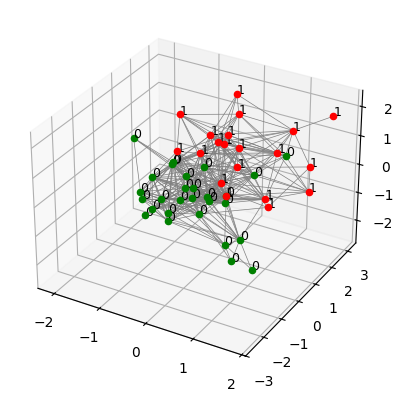

tensor([12, 12,  2,  3, 13, 16,  2,  4,  4, 18, 21, 22, 13,  9,  4, 12, 22, 12,
        12, 20, 11, 27, 10,  8, 17, 20, 22, 14,  5, 24,  8, 23, 19, 29, 19, 19,
        29, 18,  9,  1, 22, 12, 14, 25, 16, 23, 17, 26])


In [163]:
g, features, labels = create_graph(num_dim_features=3, use_plot=True)
in_degrees = torch.bincount(g.edge_index[1], minlength=g.num_nodes)
print(in_degrees)

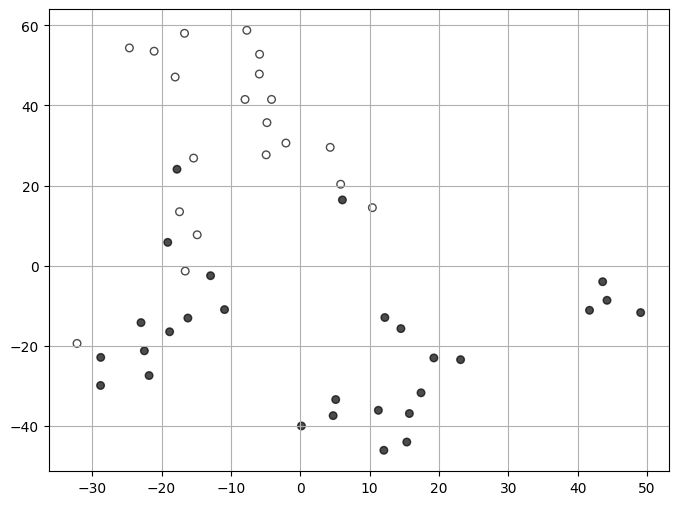

In [164]:
node_embedded = TSNE(n_components=2, perplexity=5).fit_transform(features)

x = node_embedded[:, 0]
y = node_embedded[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=30, alpha=0.7, edgecolors="k", c=labels)
plt.grid(True)
plt.show()

In [168]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# GPU not working as torch installed via pip does not fully support RTX 5090
device = torch.device("cpu")

lr = 0.003
epoch_num = 200
lambda_loss1 = 1e-2
lambda_loss2 = 1
encoder = "GCN"
sample_size = 3

hidden_dim = 2

g = g.to(device)

node_embeddings, loss, decoded = train(g, features, in_degrees, lr=lr, epoch=epoch_num, device=device, encoder=encoder, lambda_loss1=lambda_loss1, lambda_loss2=lambda_loss2, sample_size=sample_size, hidden_dim=hidden_dim)

  1%|█▉                                                                                                                                                                                                  | 2/200 [00:00<00:14, 13.56it/s]

0 2598.273681640625
1 2583.735595703125
2 2572.757080078125


  3%|█████▉                                                                                                                                                                                              | 6/200 [00:00<00:14, 13.47it/s]

3 2565.061279296875
4 2558.914794921875
5 2553.383544921875


  4%|███████▊                                                                                                                                                                                            | 8/200 [00:00<00:13, 13.74it/s]

6 2547.58984375
7 2541.3291015625
8 2534.52197265625


  6%|███████████▋                                                                                                                                                                                       | 12/200 [00:00<00:13, 14.44it/s]

9 2526.169189453125
10 2517.13720703125
11 2507.279052734375
12 2496.961181640625


  8%|███████████████▌                                                                                                                                                                                   | 16/200 [00:01<00:12, 14.78it/s]

13 2486.089111328125
14 2473.265869140625
15 2459.093505859375


  9%|█████████████████▌                                                                                                                                                                                 | 18/200 [00:01<00:12, 14.57it/s]

16 2444.728271484375
17 2430.830810546875
18 2418.31005859375


 11%|█████████████████████▍                                                                                                                                                                             | 22/200 [00:01<00:12, 14.10it/s]

19 2406.0185546875
20 2393.0927734375
21 2378.002685546875


 13%|█████████████████████████▎                                                                                                                                                                         | 26/200 [00:01<00:11, 14.61it/s]

22 2362.23828125
23 2346.0419921875
24 2329.81005859375
25 2314.15283203125


 15%|█████████████████████████████▎                                                                                                                                                                     | 30/200 [00:02<00:11, 14.93it/s]

26 2297.036376953125
27 2280.0986328125
28 2262.731201171875
29 2244.20361328125


 17%|█████████████████████████████████▏                                                                                                                                                                 | 34/200 [00:02<00:11, 15.05it/s]

30 2224.935546875
31 2205.171142578125
32 2184.60888671875
33 2163.28125


 19%|█████████████████████████████████████                                                                                                                                                              | 38/200 [00:02<00:10, 15.16it/s]

34 2141.8291015625
35 2119.600341796875
36 2097.059326171875
37 2073.568603515625


 21%|████████████████████████████████████████▉                                                                                                                                                          | 42/200 [00:02<00:10, 15.22it/s]

38 2050.234619140625
39 2025.86962890625
40 2000.3929443359375
41 1974.08740234375


 23%|████████████████████████████████████████████▊                                                                                                                                                      | 46/200 [00:03<00:10, 15.31it/s]

42 1947.12060546875
43 1919.530517578125
44 1892.1512451171875
45 1864.180908203125


 24%|██████████████████████████████████████████████▊                                                                                                                                                    | 48/200 [00:03<00:09, 15.23it/s]

46 1835.6505126953125
47 1806.4605712890625
48 1776.16357421875


 26%|██████████████████████████████████████████████████▋                                                                                                                                                | 52/200 [00:03<00:10, 14.25it/s]

49 1745.3990478515625
50 1713.893310546875
51 1682.0076904296875


 27%|████████████████████████████████████████████████████▋                                                                                                                                              | 54/200 [00:03<00:10, 14.10it/s]

52 1649.8555908203125
53 1617.0848388671875
54 1584.064697265625


 29%|████████████████████████████████████████████████████████▌                                                                                                                                          | 58/200 [00:03<00:09, 14.59it/s]

55 1550.4052734375
56 1516.1392822265625
57 1481.4779052734375
58 1446.6007080078125


 31%|████████████████████████████████████████████████████████████▍                                                                                                                                      | 62/200 [00:04<00:09, 14.80it/s]

59 1411.1658935546875
60 1375.5284423828125
61 1339.6505126953125


 32%|██████████████████████████████████████████████████████████████▍                                                                                                                                    | 64/200 [00:04<00:09, 14.42it/s]

62 1303.3790283203125
63 1267.0048828125
64 1230.480712890625


 34%|██████████████████████████████████████████████████████████████████▎                                                                                                                                | 68/200 [00:04<00:09, 14.09it/s]

65 1193.819091796875
66 1157.1087646484375
67 1120.3389892578125


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 70/200 [00:04<00:09, 13.96it/s]

68 1080.5849609375
69 1039.1240234375
70 985.8380126953125


 37%|████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 74/200 [00:05<00:09, 13.98it/s]

71 918.4691772460938
72 862.5625610351562
73 818.79736328125


 38%|██████████████████████████████████████████████████████████████████████████                                                                                                                         | 76/200 [00:05<00:08, 13.92it/s]

74 785.7908935546875
75 737.3244018554688
76 691.6908569335938


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 80/200 [00:05<00:08, 13.80it/s]

77 655.4207153320312
78 620.843994140625
79 580.5386352539062


 41%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 82/200 [00:05<00:08, 13.78it/s]

80 541.2850341796875
81 506.3349609375
82 476.3533630371094


 43%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 86/200 [00:05<00:07, 14.38it/s]

83 445.3291931152344
84 412.4466857910156
85 381.8916931152344
86 354.3621520996094


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 90/200 [00:06<00:07, 14.13it/s]

87 331.5311279296875
88 310.6334533691406
89 289.7275390625


 46%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 92/200 [00:06<00:07, 13.96it/s]

90 269.1236267089844
91 248.89114379882812
92 229.09555053710938


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 96/200 [00:06<00:07, 13.87it/s]

93 210.1468963623047
94 192.98638916015625
95 178.34910583496094


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 98/200 [00:06<00:07, 13.99it/s]

96 165.457763671875
97 153.76866149902344
98 142.86424255371094
99 132.6189727783203


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 102/200 [00:07<00:06, 14.38it/s]

100 123.59253692626953
101 115.86701202392578
102 109.3011703491211


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 106/200 [00:07<00:06, 14.09it/s]

103 103.66058349609375
104 98.39583587646484
105 94.1611099243164


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 108/200 [00:07<00:06, 13.68it/s]

106 90.6863021850586
107 87.56303405761719
108 84.74713897705078


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 112/200 [00:07<00:06, 14.25it/s]

109 82.55681610107422
110 81.17823791503906
111 80.19842529296875
112 79.35114288330078


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 116/200 [00:08<00:05, 14.49it/s]

113 78.66212463378906
114 78.17742919921875
115 77.89996337890625
116 77.82550811767578


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 120/200 [00:08<00:05, 14.51it/s]

117 77.72886657714844
118 77.60038757324219
119 77.59187316894531


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 122/200 [00:08<00:05, 14.24it/s]

120 77.72053527832031
121 77.71958923339844
122 77.53949737548828


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 126/200 [00:08<00:05, 14.38it/s]

123 77.32549285888672
124 77.12908935546875
125 76.4569320678711


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 128/200 [00:08<00:04, 14.55it/s]

126 75.57554626464844
127 74.12882995605469
128 72.38949584960938


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 132/200 [00:09<00:04, 14.33it/s]

129 70.25772857666016
130 68.07624053955078
131 65.46737670898438


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 134/200 [00:09<00:04, 14.36it/s]

132 61.96891403198242
133 58.44749450683594
134 55.26863479614258


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 138/200 [00:09<00:04, 14.19it/s]

135 52.664276123046875
136 50.091922760009766
137 47.33524703979492


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 140/200 [00:09<00:04, 14.41it/s]

138 45.05690383911133
139 42.8890380859375
140 40.525997161865234


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 144/200 [00:10<00:03, 14.03it/s]

141 39.14171600341797
142 38.20415496826172
143 37.38849639892578


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 146/200 [00:10<00:03, 14.12it/s]

144 36.419490814208984
145 35.69441604614258
146 35.07480239868164
147 34.391761779785156


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 150/200 [00:10<00:03, 14.56it/s]

148 33.60363006591797
149 33.499855041503906
150 33.06089401245117


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 154/200 [00:10<00:03, 14.56it/s]

151 32.313026428222656
152 31.47064208984375
153 30.764495849609375


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 156/200 [00:10<00:03, 14.42it/s]

154 30.20465850830078
155 29.743757247924805
156 29.460182189941406
157 29.042879104614258


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 162/200 [00:11<00:02, 14.93it/s]

158 28.54397964477539
159 28.296953201293945
160 28.203611373901367
161 28.057804107666016


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 164/200 [00:11<00:02, 14.96it/s]

162 27.886924743652344
163 27.754350662231445
164 27.67987632751465


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 168/200 [00:11<00:02, 14.57it/s]

165 27.435758590698242
166 27.170040130615234
167 26.968130111694336


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 170/200 [00:11<00:02, 14.64it/s]

168 26.662757873535156
169 26.42919158935547
170 26.347646713256836


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 174/200 [00:12<00:01, 14.81it/s]

171 26.228469848632812
172 25.97027587890625
173 25.85538673400879


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 176/200 [00:12<00:01, 14.86it/s]

174 25.727527618408203
175 25.58924674987793
176 25.477249145507812


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 180/200 [00:12<00:01, 14.77it/s]

177 25.273752212524414
178 25.192363739013672
179 24.998722076416016
180 24.831666946411133


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 184/200 [00:12<00:01, 14.55it/s]

181 24.669036865234375
182 24.575908660888672
183 24.377361297607422


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 186/200 [00:12<00:00, 14.10it/s]

184 24.31032371520996
185 24.157869338989258
186 23.980697631835938


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 190/200 [00:13<00:00, 14.38it/s]

187 23.8341064453125
188 23.667028427124023
189 23.719030380249023
190 23.66299819946289


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 194/200 [00:13<00:00, 14.71it/s]

191 23.6136531829834
192 23.514860153198242
193 23.464061737060547
194 23.30695343017578


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 198/200 [00:13<00:00, 14.68it/s]

195 23.149438858032227
196 23.043865203857422
197 22.86860466003418


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:13<00:00, 14.42it/s]

198 22.828126907348633
199 22.733808517456055


In [169]:
features

tensor([[-1.4980e+00, -3.0900e-01, -9.5755e-01],
        [-6.0884e-01, -1.8088e+00, -3.1568e-01],
        [ 1.3706e+00, -1.5132e+00, -1.6058e+00],
        [ 4.0703e-01, -7.5300e-02, -2.6710e+00],
        [ 2.1052e-01,  1.8764e-01,  1.5103e+00],
        [-1.0091e+00,  9.7139e-01, -8.9306e-01],
        [-2.2948e-01, -3.1010e+00,  3.7608e-01],
        [ 1.2105e+00,  2.2883e+00, -2.5164e-01],
        [ 6.1645e-01,  1.4471e+00, -1.5059e+00],
        [ 9.7614e-03, -1.2574e+00,  6.1652e-02],
        [-2.2072e-01,  7.6846e-01,  7.7041e-01],
        [-1.1218e+00, -5.6502e-01, -1.3806e-01],
        [ 1.2008e+00,  3.0628e-01,  1.2772e+00],
        [ 3.4628e-01, -3.1035e-01, -1.9566e+00],
        [-2.1536e+00,  9.1469e-01, -9.3281e-05],
        [ 1.2779e+00,  5.8734e-01,  1.0625e+00],
        [ 3.0992e-01,  5.2728e-01,  9.3175e-01],
        [ 4.1725e-02, -1.6779e+00,  6.5192e-01],
        [ 9.4696e-01,  1.9420e+00,  1.0814e+00],
        [-1.1128e+00,  5.5619e-01, -2.1753e-01],
        [-1.4647e+00

In [170]:
decoded

tensor([[-0.0320, -0.4327, -0.3235],
        [-0.1321, -0.7877, -0.5065],
        [-0.1321, -0.7877, -0.5065],
        [-0.1321, -0.7877, -0.5065],
        [ 0.2574,  0.7050,  0.3034],
        [ 0.0465,  0.3468,  0.2612],
        [-0.1321, -0.7877, -0.5065],
        [ 0.7774,  2.2177,  1.0369],
        [ 0.7089,  2.0016,  0.8885],
        [-0.1321, -0.7877, -0.5065],
        [ 0.0717,  0.7366,  0.5717],
        [-0.1755, -0.7658, -0.4311],
        [ 0.2817,  0.7524,  0.3136],
        [-0.1321, -0.7877, -0.5065],
        [ 0.3517,  0.8205,  0.1273],
        [ 0.3233,  0.8237,  0.3226],
        [-0.0152,  0.4229,  0.4080],
        [-0.1321, -0.7877, -0.5065],
        [ 0.4605,  2.1167,  1.2834],
        [-0.0880, -0.0600,  0.0772],
        [-0.1151, -0.7489, -0.4944],
        [-0.2242, -0.5256, -0.1564],
        [ 0.3973,  1.1491,  0.5132],
        [ 0.3189,  0.6038,  0.0820],
        [ 0.3309,  1.4603,  0.8733],
        [-0.1364, -0.7856, -0.4991],
        [-0.0416,  0.1788,  0.2273],
 

In [171]:
torch.mean((features - decoded) ** 2)

tensor(0.6341)

In [172]:
torch.mean((features - (torch.rand((features.size(0), 3)) - features.mean(dim=0, keepdim=True))) ** 2)

tensor(1.3232)

In [173]:
node_embeddings

tensor([[-0.6691, -0.7962],
        [-0.7931, -1.4085],
        [-0.7408, -1.8475],
        [-0.6792, -1.5846],
        [-0.6414, -0.5514],
        [-0.7469, -0.7282],
        [-0.6458, -1.3977],
        [-0.4623, -0.0324],
        [-0.4292, -0.0462],
        [-0.8171, -1.2449],
        [-0.7971, -0.7059],
        [-0.8683, -1.2285],
        [-0.6303, -0.5310],
        [-0.9352, -2.0267],
        [-0.4263, -0.3329],
        [-0.6097, -0.4961],
        [-0.8104, -0.7793],
        [-0.8116, -1.3802],
        [-0.7331, -0.3776],
        [-0.7818, -0.8415],
        [-0.6153, -0.8077],
        [-0.9280, -1.2214],
        [-0.6088, -0.4334],
        [-0.5206, -0.4545],
        [-0.7189, -0.4877],
        [-0.9540, -1.4596],
        [-0.7876, -0.8021],
        [-0.6333, -0.5156],
        [-0.4569, -0.2866],
        [-0.9241, -1.3729],
        [-0.5752, -0.8409],
        [-0.8386, -0.9420],
        [-0.8165, -1.1919],
        [-0.9732, -1.2994],
        [-0.7610, -0.6405],
        [-0.8395, -1

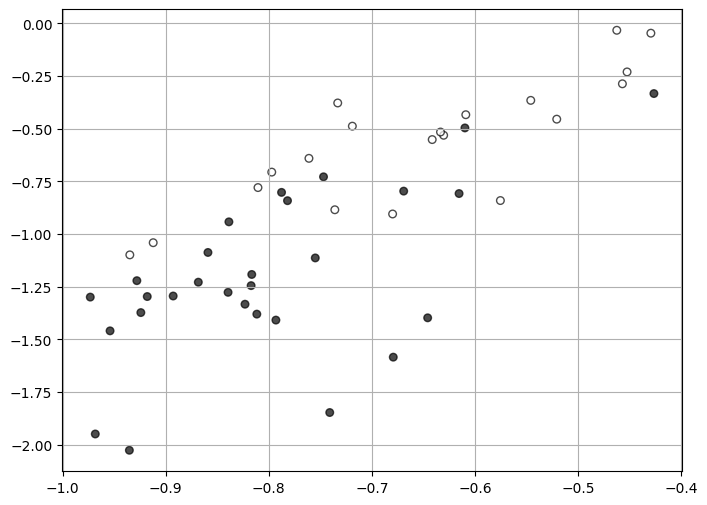

In [174]:
x = node_embeddings[:, 0]
y = node_embeddings[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=30, alpha=0.7, edgecolors="k", c=labels)
plt.grid(True)
plt.show()

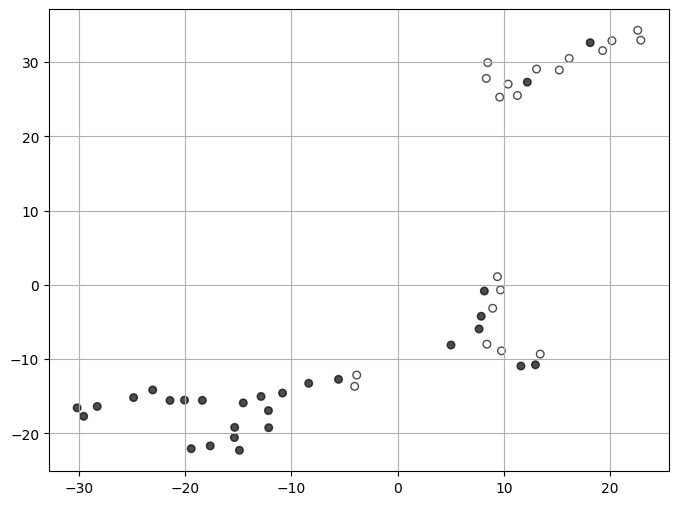

In [175]:
node_embedded = TSNE(n_components=2, perplexity=5).fit_transform(node_embeddings.cpu().detach().numpy())

x = node_embedded[:, 0]
y = node_embedded[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=30, alpha=0.7, edgecolors="k", c=labels)
plt.grid(True)
plt.show()

## 10D

In [183]:
g, features, labels = create_graph(num_dim_features=10, max_distance=3.0)
in_degrees = torch.bincount(g.edge_index[1], minlength=g.num_nodes)
print(in_degrees)

tensor([13,  6,  1,  4,  6,  4, 12,  9,  4, 12,  9,  3,  7,  3,  9,  1,  8, 19,
         9, 13,  4,  5,  5,  8,  6,  6, 11, 13, 10])


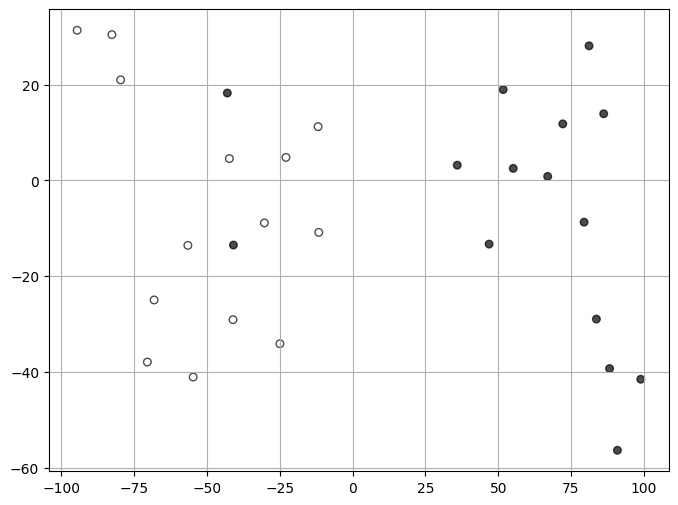

In [185]:
node_embedded = TSNE(n_components=2, perplexity=5).fit_transform(features)

x = node_embedded[:, 0]
y = node_embedded[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=30, alpha=0.7, edgecolors="k", c=labels)
plt.grid(True)
plt.show()

In [192]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# GPU not working as torch installed via pip does not fully support RTX 5090
device = torch.device("cpu")

lr = 0.003
epoch_num = 200
lambda_loss1 = 1e-2
lambda_loss2 = 1
encoder = "GCN"
sample_size = 3

hidden_dim = 2

g = g.to(device)

node_embeddings, loss, decoded = train(g, features, in_degrees, lr=lr, epoch=epoch_num, device=device, encoder=encoder, lambda_loss1=lambda_loss1, lambda_loss2=lambda_loss2, sample_size=sample_size, hidden_dim=hidden_dim)

  2%|██▉                                                                                                                                                                                                 | 3/200 [00:00<00:09, 21.81it/s]

0 748.1207885742188
1 747.9237670898438
2 747.8162231445312
3 747.7401123046875
4 747.5792846679688


  4%|████████▊                                                                                                                                                                                           | 9/200 [00:00<00:09, 20.91it/s]

5 747.496337890625
6 747.503662109375
7 747.5925903320312
8 747.398193359375
9 747.3831176757812


  8%|██████████████▋                                                                                                                                                                                    | 15/200 [00:00<00:08, 21.66it/s]

10 747.2664184570312
11 747.2493896484375
12 747.1971435546875
13 747.2499389648438
14 747.1947021484375


  9%|█████████████████▌                                                                                                                                                                                 | 18/200 [00:00<00:08, 22.20it/s]

15 747.05078125
16 747.1105346679688
17 747.1392822265625
18 747.033447265625
19 747.0823364257812


 12%|███████████████████████▍                                                                                                                                                                           | 24/200 [00:01<00:07, 22.40it/s]

20 747.0730590820312
21 747.1889038085938
22 747.0989379882812
23 747.1770629882812
24 747.1875


 15%|█████████████████████████████▎                                                                                                                                                                     | 30/200 [00:01<00:07, 22.45it/s]

25 747.0469360351562
26 747.2037963867188
27 747.1270751953125
28 747.1204833984375
29 747.1800537109375


 16%|████████████████████████████████▏                                                                                                                                                                  | 33/200 [00:01<00:07, 22.12it/s]

30 746.900390625
31 745.9544067382812
32 744.4905395507812
33 742.5988159179688
34 740.4052734375


 20%|██████████████████████████████████████                                                                                                                                                             | 39/200 [00:01<00:07, 22.19it/s]

35 738.0763549804688
36 735.5836791992188
37 732.8775634765625
38 730.2239379882812
39 727.1802368164062


 22%|███████████████████████████████████████████▉                                                                                                                                                       | 45/200 [00:02<00:07, 21.67it/s]

40 723.98828125
41 722.6058349609375
42 717.09765625
43 716.4854736328125
44 713.18408203125


 24%|██████████████████████████████████████████████▊                                                                                                                                                    | 48/200 [00:02<00:06, 22.15it/s]

45 709.7572021484375
46 706.3391723632812
47 702.5515747070312
48 698.8369140625
49 694.7871704101562


 27%|████████████████████████████████████████████████████▋                                                                                                                                              | 54/200 [00:02<00:06, 21.74it/s]

50 690.6505126953125
51 686.24267578125
52 681.3753662109375
53 676.0404663085938
54 670.2913208007812


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 60/200 [00:02<00:06, 21.76it/s]

55 664.5813598632812
56 657.2562255859375
57 644.6217041015625
58 631.7653198242188
59 618.0020141601562


 32%|█████████████████████████████████████████████████████████████▍                                                                                                                                     | 63/200 [00:02<00:06, 21.87it/s]

60 612.449462890625
61 603.2942504882812
62 590.5952758789062
63 582.9368896484375
64 574.4102783203125


 34%|███████████████████████████████████████████████████████████████████▎                                                                                                                               | 69/200 [00:03<00:06, 21.17it/s]

65 563.6932373046875
66 549.43896484375
67 538.824951171875
68 529.434326171875
69 514.5167236328125


 38%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 75/200 [00:03<00:05, 21.20it/s]

70 500.839599609375
71 490.0263671875
72 475.8486328125
73 461.28448486328125
74 449.2524108886719


 39%|████████████████████████████████████████████████████████████████████████████                                                                                                                       | 78/200 [00:03<00:05, 21.18it/s]

75 434.2877502441406
76 419.8243103027344
77 406.9723205566406
78 391.64739990234375
79 376.9180908203125


 42%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 84/200 [00:03<00:05, 21.15it/s]

80 363.84027099609375
81 348.1338806152344
82 334.2666320800781
83 320.0158386230469
84 305.8031921386719


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 90/200 [00:04<00:05, 21.01it/s]

85 291.8338623046875
86 278.35650634765625
87 265.2243957519531
88 252.25411987304688
89 240.23147583007812


 46%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 93/200 [00:04<00:05, 20.93it/s]

90 228.44859313964844
91 217.73440551757812
92 207.56381225585938
93 198.39796447753906
94 189.76927185058594


 50%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 99/200 [00:04<00:04, 21.21it/s]

95 182.08360290527344
96 175.0446319580078
97 168.91012573242188
98 163.84228515625
99 159.6678466796875


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 105/200 [00:04<00:04, 21.22it/s]

100 156.24984741210938
101 153.59774780273438
102 151.23239135742188
103 149.6009063720703
104 148.80970764160156


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 108/200 [00:04<00:04, 21.50it/s]

105 148.21636962890625
106 148.37576293945312
107 148.9656982421875
108 147.91346740722656
109 147.7528076171875


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 114/200 [00:05<00:04, 20.72it/s]

110 147.5824432373047
111 145.1648406982422
112 141.04348754882812
113 144.697265625
114 135.9402313232422


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 120/200 [00:05<00:03, 20.86it/s]

115 135.01873779296875
116 125.94120025634766
117 141.62069702148438
118 150.84213256835938
119 140.33123779296875


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 123/200 [00:05<00:03, 20.80it/s]

120 135.7926025390625
121 155.06292724609375
122 140.40863037109375
123 134.6775360107422
124 141.36114501953125


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 129/200 [00:06<00:03, 20.49it/s]

125 138.64500427246094
126 131.5277557373047
127 127.28407287597656
128 132.3378143310547
129 129.96490478515625


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 135/200 [00:06<00:02, 22.05it/s]

130 120.16976928710938
131 113.9825210571289
132 107.12973022460938
133 99.49248504638672
134 91.95636749267578


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 138/200 [00:06<00:02, 22.46it/s]

135 90.56892395019531
136 94.63882446289062
137 94.0235824584961
138 87.97870635986328
139 87.52814483642578


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 144/200 [00:06<00:02, 22.44it/s]

140 88.36566162109375
141 87.13433837890625
142 84.69683837890625
143 83.34370422363281
144 83.6134262084961


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 150/200 [00:06<00:02, 22.90it/s]

145 84.63153076171875
146 84.27316284179688
147 82.41069030761719
148 80.08905029296875
149 78.38025665283203


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 153/200 [00:07<00:02, 23.09it/s]

150 78.19440460205078
151 78.490966796875
152 78.18436431884766
153 75.89292907714844
154 74.24644470214844


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 159/200 [00:07<00:01, 23.31it/s]

155 74.78899383544922
156 75.4336929321289
157 73.75440216064453
158 72.00201416015625
159 71.67195129394531


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 165/200 [00:07<00:01, 22.57it/s]

160 71.70986938476562
161 71.09270477294922
162 70.02693176269531
163 70.241943359375
164 70.37641906738281


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 168/200 [00:07<00:01, 22.66it/s]

165 70.43452453613281
166 70.02896118164062
167 69.57456970214844
168 69.8836441040039
169 69.8364028930664


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 174/200 [00:07<00:01, 23.03it/s]

170 69.31078338623047
171 68.96160125732422
172 69.13581085205078
173 68.95581817626953
174 68.62796783447266


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 180/200 [00:08<00:00, 22.54it/s]

175 68.35917663574219
176 68.42253112792969
177 68.4556655883789
178 68.34651184082031
179 68.19337463378906


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 183/200 [00:08<00:00, 22.19it/s]

180 68.15662384033203
181 68.0380630493164
182 67.87529754638672
183 67.65876770019531
184 67.75154113769531


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 189/200 [00:08<00:00, 21.64it/s]

185 67.64629364013672
186 67.3724365234375
187 67.29479217529297
188 67.31734466552734
189 67.33809661865234


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 195/200 [00:08<00:00, 21.17it/s]

190 67.10211944580078
191 66.98799133300781
192 67.01339721679688
193 66.83650207519531
194 65.02880096435547


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 21.77it/s]

195 62.394996643066406
196 59.45298385620117
197 50.878929138183594
198 37.76605224609375
199 57.377140045166016


In [193]:
torch.mean((features - decoded) ** 2)

tensor(0.8386)

In [194]:
torch.mean((features - (torch.rand((features.size(0), 10)) - features.mean(dim=0, keepdim=True))) ** 2)

tensor(1.5096)

tensor([[13.1004,  3.8614],
        [ 1.7510, -0.2013],
        [10.0023,  3.4285],
        [10.1542,  3.4776],
        [ 1.8918, -0.6388],
        [ 0.3745, -1.2422],
        [ 2.5560, -0.8359],
        [ 5.9101,  1.0526],
        [13.5064,  4.5609],
        [ 2.6396, -0.7500],
        [13.3368,  4.3964],
        [ 0.3530, -1.1339],
        [ 0.4425, -1.5851],
        [ 0.4093, -1.4178],
        [14.9836,  4.9286],
        [11.4913,  3.9097],
        [ 1.5885, -0.9343],
        [ 5.8510,  0.0198],
        [ 2.7835, -0.3840],
        [ 2.7318, -0.9708],
        [11.0370,  3.7629],
        [10.7794,  3.6797],
        [10.7807,  3.6801],
        [12.6779,  4.0935],
        [ 0.4322, -1.5332],
        [ 0.3935, -1.3380],
        [15.1515,  4.9924],
        [ 2.5822, -0.8937],
        [ 8.3582,  2.2787]])


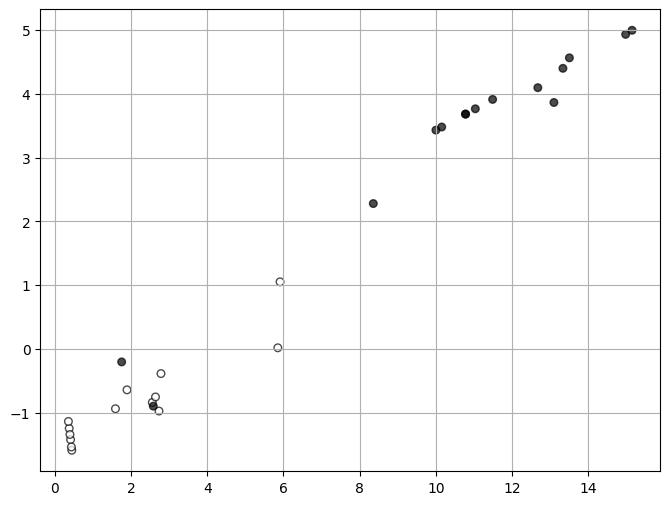

In [195]:
print(node_embeddings)

x = node_embeddings[:, 0]
y = node_embeddings[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=30, alpha=0.7, edgecolors="k", c=labels)
plt.grid(True)
plt.show()

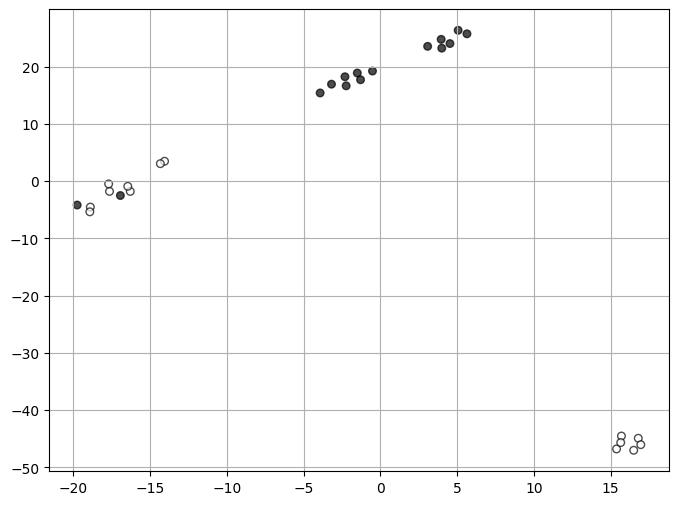

In [196]:
node_embedded = TSNE(n_components=2, perplexity=5).fit_transform(node_embeddings.cpu().detach().numpy())

x = node_embedded[:, 0]
y = node_embedded[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=30, alpha=0.7, edgecolors="k", c=labels)
plt.grid(True)
plt.show()

In [ ]:
# def train_new_datasets(epoch_num=10, lr=5e-6, encoder="GCN", lambda_loss1=1e-4, lambda_loss2=1, sample_size=10, hidden_dim=None):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     g, labels = utils.read_real_datasets(dataset_str)
#     g = g.to(device)

#     node_labels = labels
#     # attr, feat
#     if hidden_dim == None:
#         hidden_dim = g.ndata["attr"].shape[1]
#     else:
#         hidden_dim = hidden_dim

#     acc = []
#     for index in range(5):
#         node_embeddings, loss = train(g, g.ndata["attr"], lr=lr, epoch=epoch_num, device=device, encoder=encoder, lambda_loss1=lambda_loss1, lambda_loss2=lambda_loss2, sample_size=sample_size, hidden_dim=hidden_dim)
#         input_dims = node_embeddings.shape
#         print(input_dims[1])

#         FNN = MLP(num_layers=4, input_dim=input_dims[1], hidden_dim=input_dims[1] // 2, output_dim=class_number).to(device)
#         FNN = FNN.to(device)

#         criterion = torch.nn.CrossEntropyLoss()
#         optimizer = torch.optim.Adam(FNN.parameters())

#         dataset = NodeClassificationDataset(node_embeddings, node_labels)
#         split = utils.DataSplit(dataset, shuffle=True)
#         train_loader, val_loader, test_loader = split.get_split(batch_size=64, num_workers=0)
#         # train_loader = DataLoader(dataset=dataset, batch_size=32, shuffle=True)
#         best = -float("inf")
#         for epoch in range(50):
#             for i, data in enumerate(train_loader, 0):
#                 # data = data.to(device)
#                 inputs, labels = data
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)
#                 y_pred = FNN(inputs)
#                 loss = criterion(y_pred, labels)
#                 # train_loss = loss
#                 print(epoch, i, loss.item())
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()

#                 with torch.no_grad():
#                     correct = 0
#                     total = 0
#                     for data in val_loader:
#                         inputs, labels = data
#                         inputs = inputs.to(device)
#                         labels = labels.to(device)
#                         outputs = FNN(inputs)
#                         _, predicted = torch.max(outputs.data, 1)
#                         loss = criterion(outputs, labels)
#                         total += labels.size(0)
#                         correct += torch.sum(predicted == labels)
#                 if correct / total > best:
#                     best = correct / total
#                     torch.save(FNN.state_dict(), "best_mlp_{}.pkl".format(index))
#                 print(str(epoch), correct / total)

#         with torch.no_grad():
#             FNN.load_state_dict(torch.load("best_mlp_{}.pkl".format(index)))
#             correct = 0
#             total = 0
#             for data in test_loader:
#                 inputs, labels = data
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)
#                 outputs = FNN(inputs)
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
#                 correct += torch.sum(predicted == labels)
#         print((correct / total).item())
#         acc.append((correct / total).item())

#     print("mean:")
#     print(statistics.mean(acc))
#     print("std:")
#     print(statistics.stdev(acc))

In [ ]:
# train_new_datasets(lr=5e-7, epoch_num=50, lambda_loss1=1e-2, lambda_loss2=1, encoder="GCN", sample_size=5, hidden_dim=512)